In [1]:
##########################################################
## Simulation of an SRC neuron - Pascal - FPGA test     ##
##########################################################
## Modification from NeSRC3E -> FPGA FORM               ##
##  Transformation of the NeSRC3 library into an        ##
##  FPGA version - integer format (16-bit signed).      ##
##                                                      ## 
##  !! Preparatory session - lib FpgaLib-01         !!  ##
##  !!  - hybrid function  NeSRC3Fpga!()            !!  ## 
##  !!  - FPGA function    NeSRC3Fpga2!()           !!  ## 
##  !!  - FPGA function    NeSRC3Fpga5!()           !!  ##
##  !! Final version session - lib FpgaLib-02       !!  ##
##  !!  - FPGA function    NeSRC3Fpga5!()           !!  ##
##                                     18 December 2023 ##
##                                     09 January  2024 ##
##                                     19 December 2025 ##
##########################################################

using Plots
# use of my lib for the neuro model - personal and Florent's - for reference
# def using my lib -> neuron with struct and function - spike inputs via vectors
include("../MyLib/Fpgalib-02.jl")

# Implementation of an SRC 'Florent' version with Harmeling Pascal modifications
# removal of the zst equation -> hysteresis cycle function with variable threshold.
# modification using two ReLu equations instead of tanh
# Harmeling - December 2023 -> validation of the library function - NeSRC3Fpga2!
#   - modification of the order of operations
#   - modification via scaling -> replacement of float by int (!! int32 for the operation 999/1000*(nhst-nht))
# Harmeling - January  2024 -> validation of the library function - NeSRC3Fpga3!
#   - implementation of an algorithm to remove 999/1000 -> int32 replaced by int16

NeSRC3Fpga5! (generic function with 1 method)

In [2]:
# differential computation time
#------------------------------
const bEnd::Float32=50.0
const bStep::Float32=0.1
const TableSize::Int32 = bEnd/bStep

500

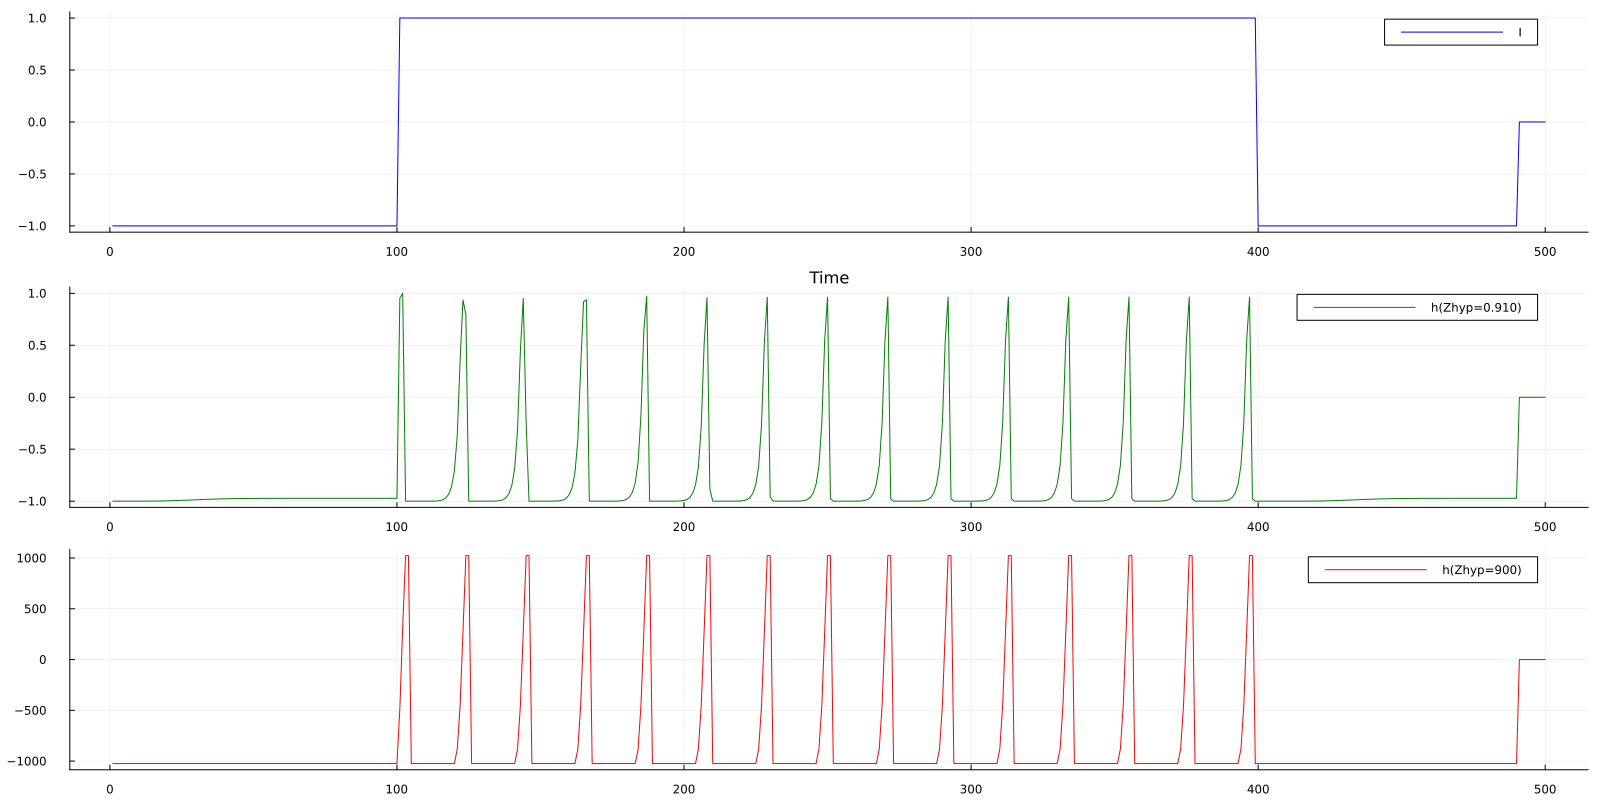

In [3]:
# use of NeSRC3Fpga with 5 arguments - R, rs, bias, Zmaw and Zmin (Fpgalib-02)
# ----------------------------------------------------------------------------
# Initialization of the computation vectors - Florent format - float
#-------------------------------------------------------------------
h=Vector{Float32}(undef,TableSize)
hs=Vector{Float32}(undef,TableSize)
zs=Vector{Float32}(undef,TableSize)
x=Vector{Float32}(undef,TableSize)

h=zeros(TableSize)
hs=zeros(TableSize)
zs=zeros(TableSize)
x=zeros(TableSize)

#condition initiale
ht::Float64=0.0
ht1::Float64=0.0
hst::Float64=0.0
hst1::Float64=0.0
zst::Float64=0.1
xt::Float64=-1

pointeur::Int32=1

# Initialization of the computation vectors - FPGA format - INT
#--------------------------------------------------------------
Fh=Vector{Int16}(undef,TableSize)
Fhs=Vector{Int16}(undef,TableSize)
Fzs=Vector{Int16}(undef,TableSize)
Fx=Vector{Int16}(undef,TableSize)

Fh=zeros(TableSize)
Fhs=zeros(TableSize)
Fzs=zeros(TableSize)
Fx=zeros(TableSize)

#condition initiale
Fht::Int16=0
Fht1::Int16=0
Fhst::Int16=0
Fhst1::Int16=0
Fzst::Int16=100
Fxt::Int16=-1000

# Initialization of the initial conditions and parameters
#--------------------------------------------------------
const r::Float32 = 2  # constant for the Update part - updated value
const rs::Float32 = -7
const bias::Float32 = -5
const zshyp::Float32 = 0.91 # 0.9345
const zsdep::Float32 = 0.0

const Fparam=Vector{Int16}(undef,5)
Fparam[1] = -3000
Fparam[2] = 900 #935   # modification - allows adapting the spike frequency - WARNING BEFORE 0.99 -> coeff. 1000 - 970 to 999
Fparam[3] = 100

# computation of the three equations h, zst and hs
# the injected current must be lower than 3
for i in 1.0:bStep:bEnd
 
    if ((pointeur>100) && (pointeur<400))
        xt=1 
        Fxt=1000 
    else 
        xt=-1
        Fxt=-1000
    end

    #-- FLOAT Florent --
    ht1 = tanh(2*xt+r*ht+rs*hst+bias)
    h[pointeur] = ht1
    
    zst =zshyp-(zshyp-zsdep)*(1/(1+exp(-10*(ht-0.5))))
    zs[pointeur] = zst

    hst1 = zst*hst+(1-zst)*ht
    hs[pointeur] = hst1
    
    ht = ht1
    hst = hst1
    #-- INT VHDL --
    Fx[pointeur] = Fxt
    Fh[pointeur],Fhs[pointeur],Fzs[pointeur]=NeSRC3Fpga5!(Fxt,Fht,Fhst, Fparam)

    Fht=Fh[pointeur]
    Fhst=Fhs[pointeur]
 
    #-- Next point --
    x[pointeur] = xt
    pointeur+=1
end

p0=plot(x, xlabel="Time",label="I",  linecolor = :blue)

p1=plot(size = (1600, 800))
p1=plot!(h,label="h(Zhyp=0.910)",linecolor = :green)

p2=plot(size = (1600, 800))
p2=plot!(Fh,label="h(Zhyp=900)",  linecolor = :red)

plot!(p0,p1,p2, layout = (3, 1))

#savefig("FloVSNeSRC3Fpga5(Zhyp0-910_Zhypvhdl902).pdf")


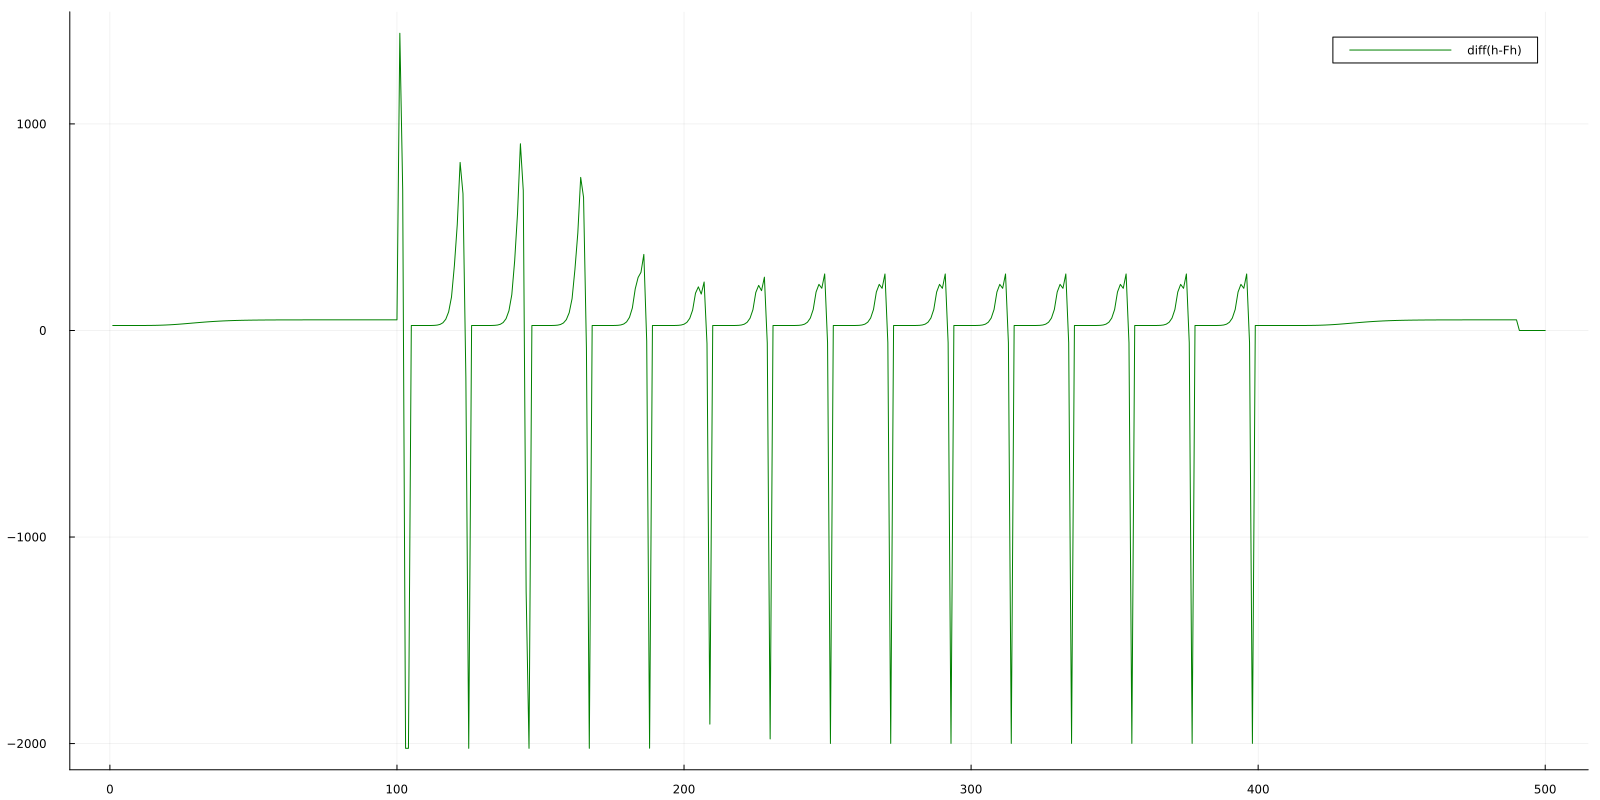

In [4]:
plot(size = (1600, 800))
plot!(((1000*h)-Fh),label="diff(h-Fh)",linecolor = :green)

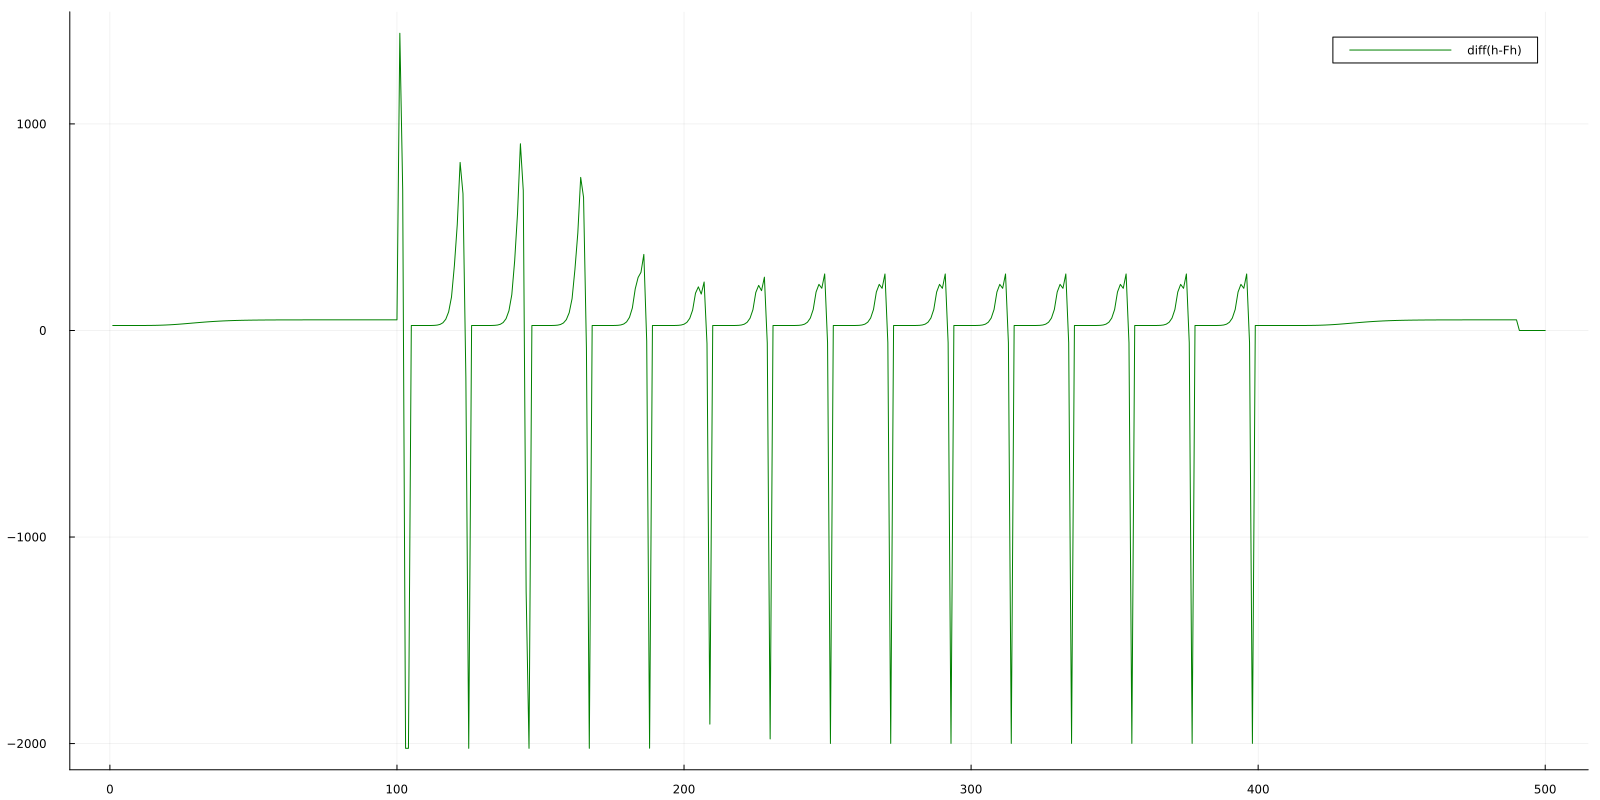

In [5]:
plot(size = (1600, 800))
plot!(((1000*h)-Fh),label="diff(h-Fh)",linecolor = :green)

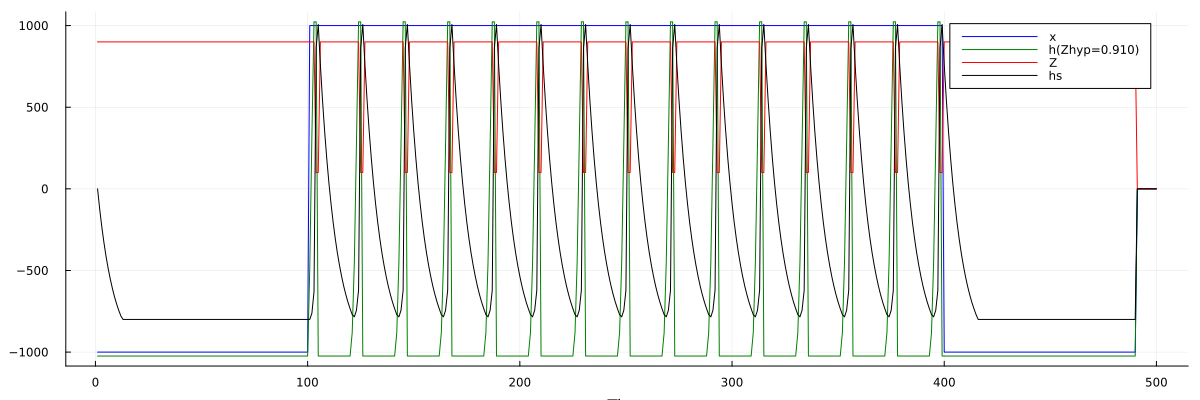

In [6]:
# Full picture 
# ------------

plot(size = (1200, 400))
plot!(Fx, xlabel="Time",label="x",  linecolor = :blue)
plot!(Fh,label="h(Zhyp=0.910)",linecolor = :green)
plot!(Fzs,label="Z",  linecolor = :red)
plot!(Fhs,label="hs",linecolor = :black)


In [7]:
# --------------------------------------------------------------------------
# Initialization of the computation vectors - FPGA format - INT - MULTIPLE Z
#---------------------------------------------------------------------------
#-- 880
FhM880=Vector{Int16}(undef,TableSize)
FhsM880=Vector{Int16}(undef,TableSize)
FzsM880=Vector{Int16}(undef,TableSize)
Fx=Vector{Int16}(undef,TableSize)

FhM880=zeros(TableSize)
FhsM880=zeros(TableSize)
FzsM880=zeros(TableSize)

#-- 900
FhM900=Vector{Int16}(undef,TableSize)
FhsM900=Vector{Int16}(undef,TableSize)
FzsM900=Vector{Int16}(undef,TableSize)

FhM900=zeros(TableSize)
FhsM900=zeros(TableSize)
FzsM900=zeros(TableSize)

#-- 920
FhM920=Vector{Int16}(undef,TableSize)
FhsM920=Vector{Int16}(undef,TableSize)
FzsM920=Vector{Int16}(undef,TableSize)

FhM920=zeros(TableSize)
FhsM920=zeros(TableSize)
FzsM920=zeros(TableSize)

#-- 940
FhM940=Vector{Int16}(undef,TableSize)
FhsM940=Vector{Int16}(undef,TableSize)
FzsM940=Vector{Int16}(undef,TableSize)

FhM940=zeros(TableSize)
FhsM940=zeros(TableSize)
FzsM940=zeros(TableSize)

#-- 960
FhM960=Vector{Int16}(undef,TableSize)
FhsM960=Vector{Int16}(undef,TableSize)
FzsM960=Vector{Int16}(undef,TableSize)

FhM960=zeros(TableSize)
FhsM960=zeros(TableSize)
FzsM960=zeros(TableSize)

#-- 980
FhM980=Vector{Int16}(undef,TableSize)
FhsM980=Vector{Int16}(undef,TableSize)
FzsM980=Vector{Int16}(undef,TableSize)

FhM980=zeros(TableSize)
FhsM980=zeros(TableSize)
FzsM980=zeros(TableSize)

#-- 1000
FhM1000=Vector{Int16}(undef,TableSize)
FhsM1000=Vector{Int16}(undef,TableSize)
FzsM1000=Vector{Int16}(undef,TableSize)

FhM1000=zeros(TableSize)
FhsM1000=zeros(TableSize)
FzsM1000=zeros(TableSize)

#condition initiale
Fht::Int16=0
Fht1::Int16=0
Fhst::Int16=0
Fhst1::Int16=0
Fzst::Int16=100
Fxt::Int16=-1000

# Initialization of the initial conditions and parameters - 880
#--------------------------------------------------------------
pointeur::Int32=1
Fx=zeros(TableSize)

const Fparam=Vector{Int16}(undef,5)
Fparam[1] = -3000
Fparam[2] = 880 # -------> 880
Fparam[3] = 100

for i in 1.0:bStep:bEnd
 
    if ((pointeur>100) && (pointeur<400))
        Fxt=1000 
    else 
        Fxt=-1000
    end
    #-- INT VHDL --
    Fx[pointeur] = Fxt
    FhM880[pointeur],FhsM880[pointeur],FzsM880[pointeur]=NeSRC3Fpga5!(Fxt,Fht,Fhst, Fparam)

    Fht=FhM880[pointeur]
    Fhst=FhsM880[pointeur]
 
    #-- Next point --
    pointeur+=1
end

# Initialization of the initial conditions and parameters - 900
#--------------------------------------------------------------
pointeur::Int32=1
Fx=zeros(TableSize)

const Fparam=Vector{Int16}(undef,5)
Fparam[1] = -3000
Fparam[2] = 900 # -------> 900
Fparam[3] = 100

#calcul des trois équation h,zst et hs
#le courant injecté doit être inférieure à 3
for i in 1.0:bStep:bEnd
 
    if ((pointeur>100) && (pointeur<400))
        Fxt=1000 
    else 
        Fxt=-1000
    end
    #-- INT VHDL --
    Fx[pointeur] = Fxt
    FhM900[pointeur],FhsM900[pointeur],FzsM900[pointeur]=NeSRC3Fpga5!(Fxt,Fht,Fhst, Fparam)

    Fht=FhM900[pointeur]
    Fhst=FhsM900[pointeur]
 
    #-- Next point --
    pointeur+=1
end

# Initialization of the initial conditions and parameters - 920
#--------------------------------------------------------------
pointeur::Int32=1
Fx=zeros(TableSize)

const Fparam=Vector{Int16}(undef,5)
Fparam[1] = -3000
Fparam[2] = 920 # -------> 920
Fparam[3] = 100

#calcul des trois équation h,zst et hs
#le courant injecté doit être inférieure à 3
for i in 1.0:bStep:bEnd
 
    if ((pointeur>100) && (pointeur<400))
        Fxt=1000 
    else 
        Fxt=-1000
    end
    #-- INT VHDL --
    Fx[pointeur] = Fxt
    FhM920[pointeur],FhsM920[pointeur],FzsM920[pointeur]=NeSRC3Fpga5!(Fxt,Fht,Fhst, Fparam)

    Fht=FhM920[pointeur]
    Fhst=FhsM920[pointeur]
 
    #-- Next point --
    pointeur+=1
end

# Initialization of the initial conditions and parameters - 940
#--------------------------------------------------------------
pointeur::Int32=1
Fx=zeros(TableSize)

const Fparam=Vector{Int16}(undef,5)
Fparam[1] = -3000
Fparam[2] = 940 # -------> 940
Fparam[3] = 100

#calcul des trois équation h,zst et hs
#le courant injecté doit être inférieure à 3
for i in 1.0:bStep:bEnd
 
    if ((pointeur>100) && (pointeur<400))
        Fxt=1000 
    else 
        Fxt=-1000
    end
    #-- INT VHDL --
    Fx[pointeur] = Fxt
    FhM940[pointeur],FhsM940[pointeur],FzsM940[pointeur]=NeSRC3Fpga5!(Fxt,Fht,Fhst, Fparam)

    Fht=FhM940[pointeur]
    Fhst=FhsM940[pointeur]
 
    #-- Next point --
    pointeur+=1
end

# Initialization of the initial conditions and parameters - 960
#--------------------------------------------------------------
pointeur::Int32=1
Fx=zeros(TableSize)

const Fparam=Vector{Int16}(undef,5)
Fparam[1] = -3000
Fparam[2] = 960 # -------> 960
Fparam[3] = 100

#calcul des trois équation h,zst et hs
#le courant injecté doit être inférieure à 3
for i in 1.0:bStep:bEnd
 
    if ((pointeur>100) && (pointeur<400))
        Fxt=1000 
    else 
        Fxt=-1000
    end
    #-- INT VHDL --
    Fx[pointeur] = Fxt
    FhM960[pointeur],FhsM960[pointeur],FzsM960[pointeur]=NeSRC3Fpga5!(Fxt,Fht,Fhst, Fparam)

    Fht=FhM960[pointeur]
    Fhst=FhsM960[pointeur]
 
    #-- Next point --
    pointeur+=1
end

# Initialization of the initial conditions and parameters - 980
#--------------------------------------------------------------
pointeur::Int32=1
Fx=zeros(TableSize)

const Fparam=Vector{Int16}(undef,5)
Fparam[1] = -3000
Fparam[2] = 980 # -------> 980
Fparam[3] = 100

#calcul des trois équation h,zst et hs
#le courant injecté doit être inférieure à 3
for i in 1.0:bStep:bEnd
 
    if ((pointeur>100) && (pointeur<400))
        Fxt=1000 
    else 
        Fxt=-1000
    end
    #-- INT VHDL --
    Fx[pointeur] = Fxt
    FhM980[pointeur],FhsM980[pointeur],FzsM980[pointeur]=NeSRC3Fpga5!(Fxt,Fht,Fhst, Fparam)

    Fht=FhM980[pointeur]
    Fhst=FhsM980[pointeur]
 
    #-- Next point --
    pointeur+=1
end

# Initialization of the initial conditions and parameters - 1000
#---------------------------------------------------------------
pointeur::Int32=1
Fx=zeros(TableSize)

const Fparam=Vector{Int16}(undef,5)
Fparam[1] = -3000
Fparam[2] = 1000 # -------> 1000
Fparam[3] = 100

#calcul des trois équation h,zst et hs
#le courant injecté doit être inférieure à 3
for i in 1.0:bStep:bEnd
 
    if ((pointeur>100) && (pointeur<400))
        Fxt=1000 
    else 
        Fxt=-1000
    end
    #-- INT VHDL --
    Fx[pointeur] = Fxt
    FhM1000[pointeur],FhsM1000[pointeur],FzsM1000[pointeur]=NeSRC3Fpga5!(Fxt,Fht,Fhst, Fparam)

    Fht=FhM1000[pointeur]
    Fhst=FhsM1000[pointeur]
 
    #-- Next point --
    pointeur+=1
end

p0=plot(Fx, xlabel="Time",label="I",  linecolor = :blue)

p1=plot(size = (1600, 1800))
p1=plot!(FhM880,label="h(Zhyp=880)",linecolor = :green)

p2=plot(size = (1600, 1800))
p2=plot!(FhM900,label="h(Zhyp=900)",  linecolor = :red)

p3=plot(size = (1600, 1800))
p3=plot!(FhM920,label="h(Zhyp=920)",  linecolor = :red)

p4=plot(size = (1600, 1800))
p4=plot!(FhM940,label="h(Zhyp=940)",  linecolor = :red)

p5=plot(size = (1600, 1800))
p5=plot!(FhM960,label="h(Zhyp=960)",  linecolor = :red)

p6=plot(size = (1600, 1800))
p6=plot!(FhM980,label="h(Zhyp=980)",  linecolor = :red)

p7=plot(size = (1600, 1800))
p7=plot!(FhM1000,label="h(Zhyp=1000)",  linecolor = :red)

plot!(p0,p1,p2,p3,p4,p5,p6,p7, layout = (8, 1))

savefig("FloVSNeSRC3Fpga5(Zhyp880to1000).pdf")


"F:\\PH_01\\ULg_Cours\\AC_2017-20XX-Phd\\Article\\Article - 01\\C01 - Code article\\Julia\\12 - RNN-SRC-NFPGA 01\\FloVSNeSRC3Fpga5(Zhyp880to1000).pdf"